# Feature Engineering Notebook
-   This notebook intakes the financial market data store in the custom arcticdb database, and adds more features to it so it simulates level 2 tick data.

## Steps:
    1. Download the finanical data from the custom arcticdb database (financial_data folder)
    2. Add more features 
    3. Plot, visualize and save the features
    4. Save the data as processed data, ready for reinforcement learning model prototying.

In [8]:
# Ensure src/ is in the Python path for imports
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [9]:
# Load data from ArcticDB and apply FeatureEngineer
import pandas as pd
import yaml
from src.data.arcticdb_store import ArcticDBStore
from src.data.feature_pipeline import FeatureEngineer

# Load feature config
def load_feature_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

# Connect to ArcticDB and list available symbols
# Use the main financial_data directory at the project root
project_db_path = os.path.abspath(os.path.join(os.getcwd(), "..", "financial_data"))
db_store = ArcticDBStore(db_url=f"lmdb://{project_db_path}", library_name="futures_intraday")
available_symbols = db_store.list_symbols()  # List all available symbols
print(f"Available symbols in ArcticDB: {available_symbols}")

# Use the first available symbol, or raise an error if none exist
if not available_symbols:
    raise ValueError("No symbols found in ArcticDB library 'futures_intraday'. Please ingest data first.")
ticker = available_symbols[0]
raw_data = db_store.read(ticker)

# Load feature config
yaml_path = "../config/data/features.yaml"
feature_config = load_feature_config(yaml_path)["features"]

# Engineer features
gen = FeatureEngineer(config={"features": feature_config})
features_df = gen.engineer_features(raw_data, feature_config=feature_config)

# Show sample
features_df.head()

Available symbols in ArcticDB: ['ENGINEERED/SAMPLE']


Price,close,high,low,open,volume,returns_1,returns_5,returns_15,volatility_5,volatility_15,...,ma_5,ma_15,ma_30,rsi,macd_macd,macd_signal,macd_histogram,imbalance_5,imbalance_15,spread_proxy
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-03-06,153.723145,154.074416,153.396392,153.747663,82516500,0.002288,0.012620,0.033007,0.007503,0.005216,...,152.723242,151.260472,148.591682,73.957134,1.344537,1.089571,0.254966,0.489373,0.379962,0.004411
2014-03-07,153.788452,154.360288,153.110429,154.360288,114513500,0.000425,0.010519,0.028283,0.007562,0.005167,...,153.045093,151.546384,148.740628,71.500559,1.392015,1.150108,0.241907,0.459487,0.384993,0.008127
2014-03-10,153.706802,153.763978,152.824555,153.551590,74939200,-0.000531,0.017045,0.022248,0.005984,0.005100,...,153.564645,151.771847,148.993049,70.123043,1.406998,1.201518,0.205479,0.716081,0.289046,0.006112
2014-03-11,152.947128,154.156141,152.595870,153.935576,99009100,-0.004955,-0.001867,0.016099,0.002755,0.005365,...,153.507477,151.934682,149.244109,72.275470,1.345911,1.230412,0.115499,0.242641,0.181514,0.010201
2014-03-12,152.987961,153.045149,151.860643,152.203749,104824400,0.000267,-0.002506,0.023010,0.002695,0.004935,...,153.430698,152.166682,149.467666,68.883910,1.285682,1.241470,0.044212,0.268822,0.320151,0.007742


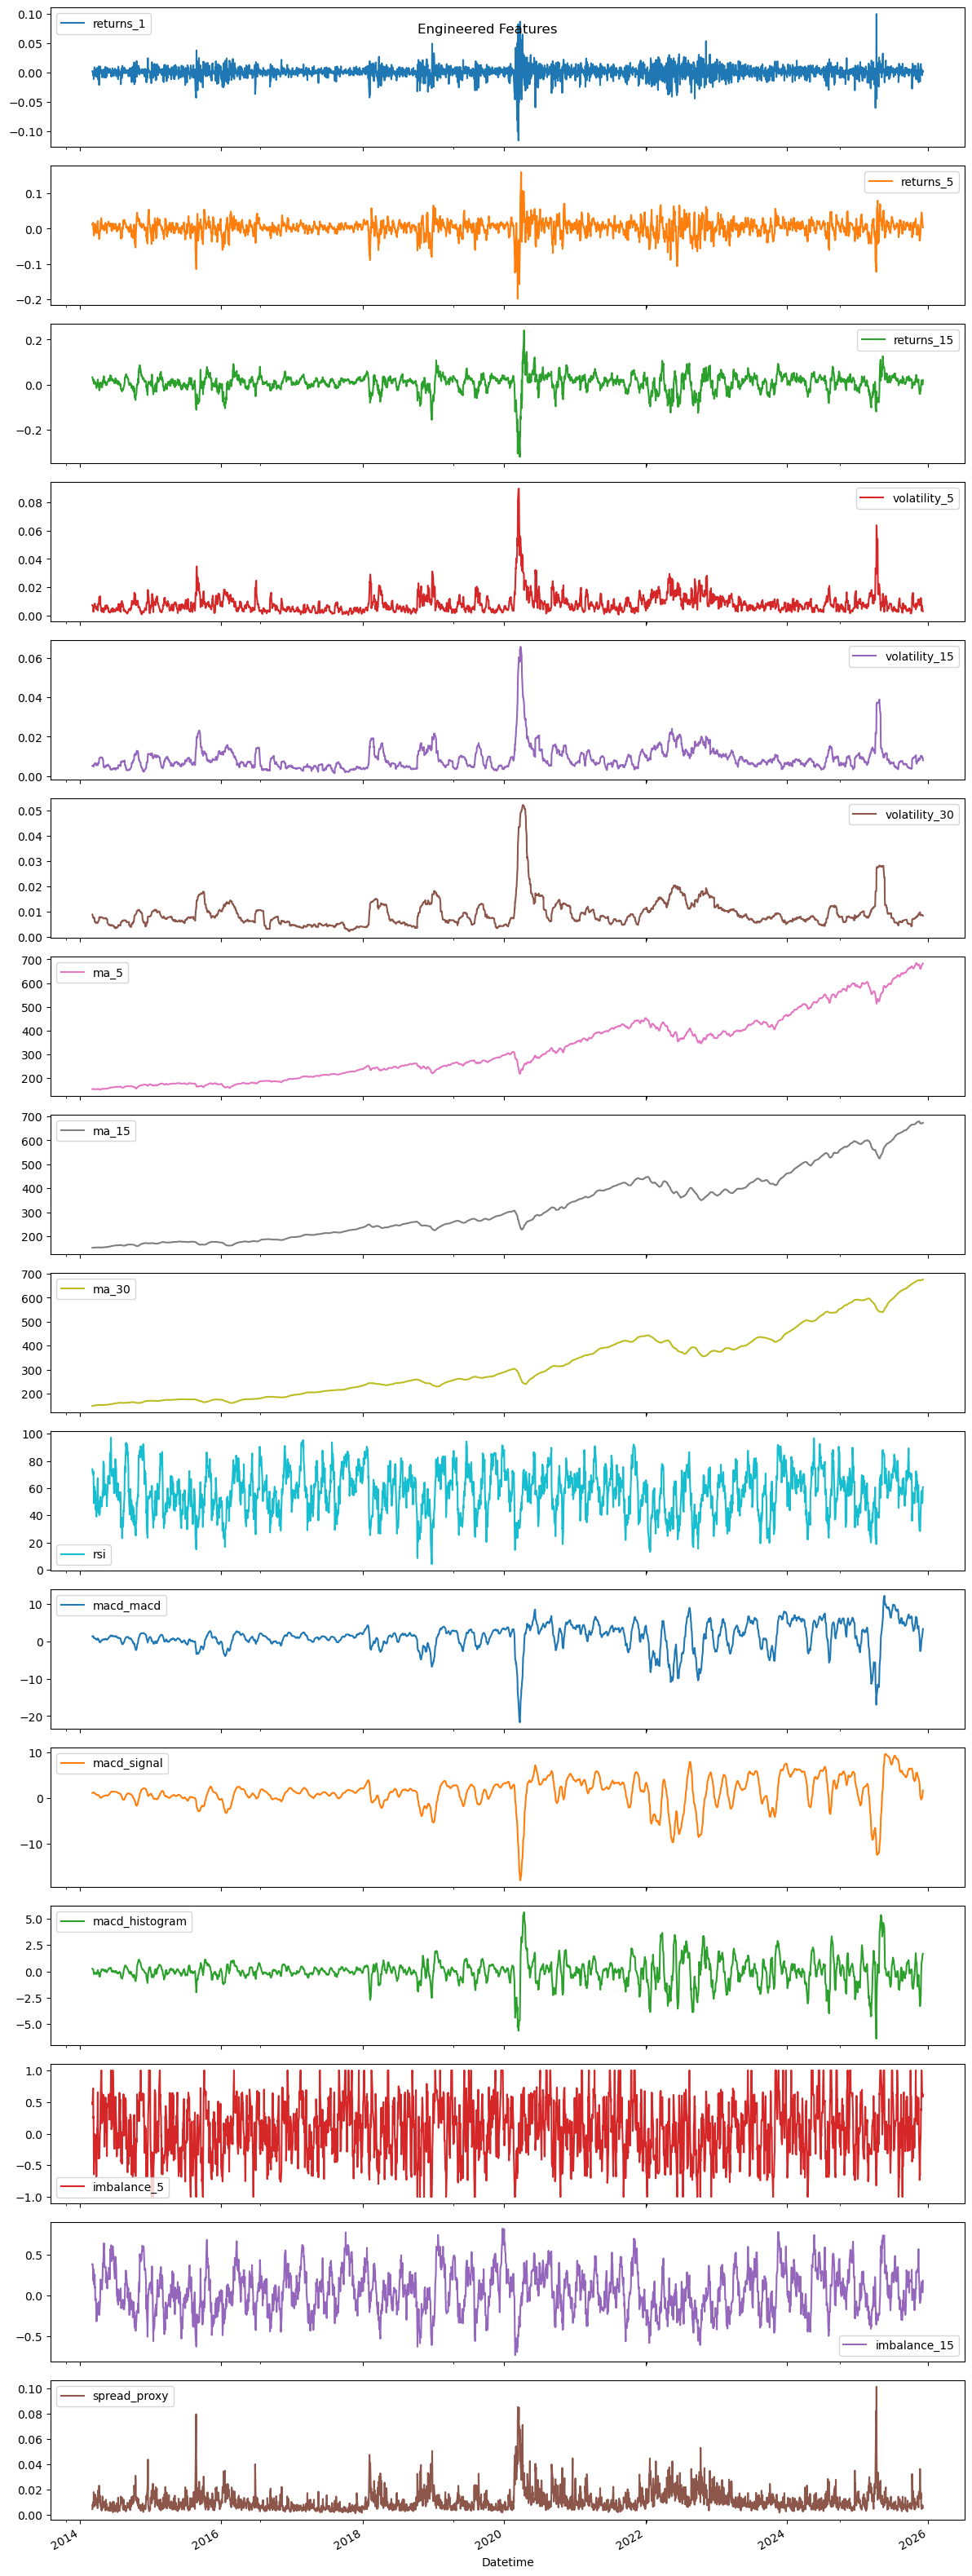

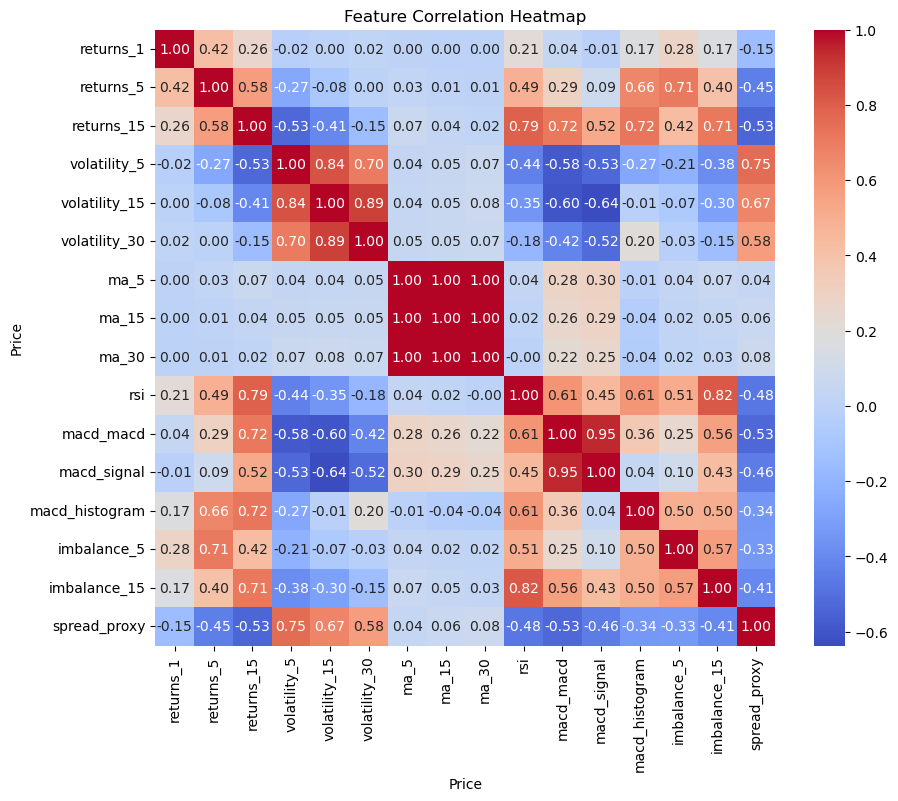

Processed features saved to ../data/store/processed_features.csv


In [10]:
# Visualize and save engineered features
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a selection of features
feature_cols = [col for col in features_df.columns if col not in ["open", "high", "low", "close", "volume"]]
features_df[feature_cols].plot(subplots=True, figsize=(12, 2 * len(feature_cols)), title="Engineered Features")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(features_df[feature_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Save processed features to CSV
features_df.to_csv("../data/store/processed_features.csv")
print("Processed features saved to ../data/store/processed_features.csv")

In [11]:
# Advanced feature engineering and analysis
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Outlier removal (z-score method)
def remove_outliers(df, cols, threshold=3):
    z = np.abs((df[cols] - df[cols].mean()) / df[cols].std())
    return df[(z < threshold).all(axis=1)]

clean_features_df = remove_outliers(features_df, feature_cols)
print(f"Removed outliers: {len(features_df) - len(clean_features_df)} rows dropped.")

# Add rolling quantiles and lagged features
for col in feature_cols:
    clean_features_df[f"{col}_q25"] = clean_features_df[col].rolling(20).quantile(0.25)
    clean_features_df[f"{col}_q75"] = clean_features_df[col].rolling(20).quantile(0.75)
    clean_features_df[f"{col}_lag1"] = clean_features_df[col].shift(1)

# Data quality summary
print(clean_features_df.describe().T)

# Feature importance (using RandomForest on next-period return as target)
if "returns_1" in clean_features_df.columns:
    X = clean_features_df.dropna().drop(columns=["returns_1"])
    y = clean_features_df.dropna()["returns_1"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    importance_df = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
    print("Top 10 Feature Importances:")
    print(importance_df.head(10))
else:
    print("returns_1 not found for feature importance analysis.")

Removed outliers: 172 rows dropped.
                    count          mean           std           min  \
Price                                                                 
close              2786.0  3.220737e+02  1.417636e+02  1.489288e+02   
high               2786.0  3.235474e+02  1.424264e+02  1.504551e+02   
low                2786.0  3.202947e+02  1.409655e+02  1.487647e+02   
open               2786.0  3.219958e+02  1.417525e+02  1.494457e+02   
volume             2786.0  8.348144e+07  3.677649e+07  2.027000e+07   
...                   ...           ...           ...           ...   
imbalance_15_q75   2767.0  1.754999e-01  1.998502e-01 -2.538638e-01   
imbalance_15_lag1  2785.0  6.029788e-02  2.512572e-01 -6.042091e-01   
spread_proxy_q25   2767.0  6.882857e-03  2.754055e-03  2.679607e-03   
spread_proxy_q75   2767.0  1.208549e-02  4.757600e-03  4.074764e-03   
spread_proxy_lag1  2785.0  9.921151e-03  5.866143e-03  1.229096e-03   

                            25%         

/tmp/ipykernel_12714/3830429969.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_features_df[f"{col}_q25"] = clean_features_df[col].rolling(20).quantile(0.25)
/tmp/ipykernel_12714/3830429969.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_features_df[f"{col}_q75"] = clean_features_df[col].rolling(20).quantile(0.75)
/tmp/ipykernel_12714/3830429969.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Top 10 Feature Importances:
              feature  importance
5           returns_5    0.250113
25     returns_5_lag1    0.196518
19       spread_proxy    0.117740
7        volatility_5    0.047930
17        imbalance_5    0.031023
4              volume    0.025146
31  volatility_5_lag1    0.019182
6          returns_15    0.019055
61   imbalance_5_lag1    0.017145
13                rsi    0.016697


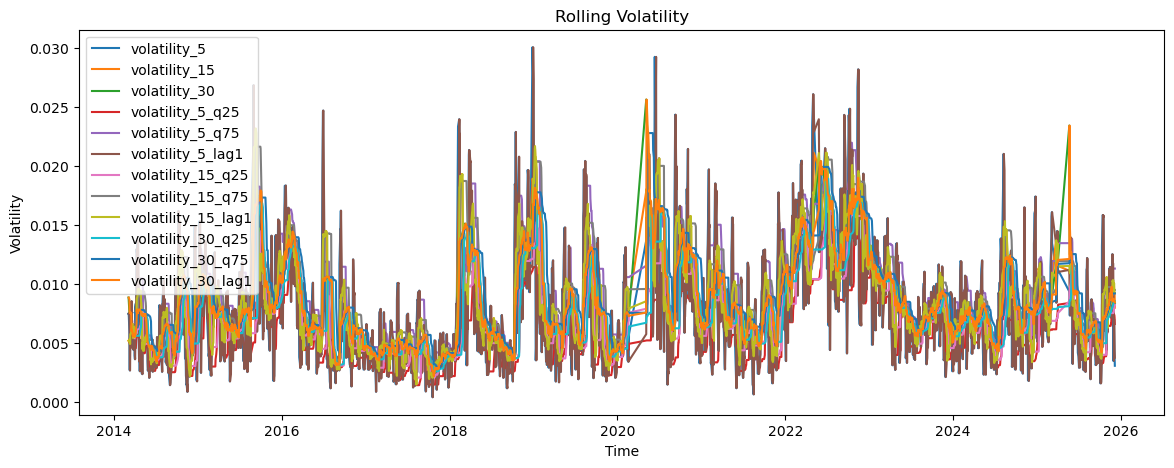

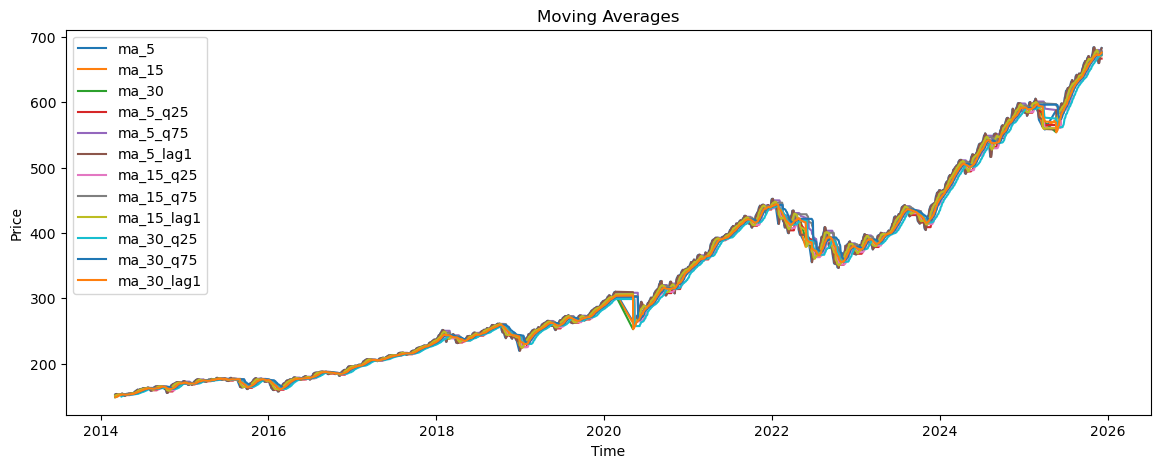

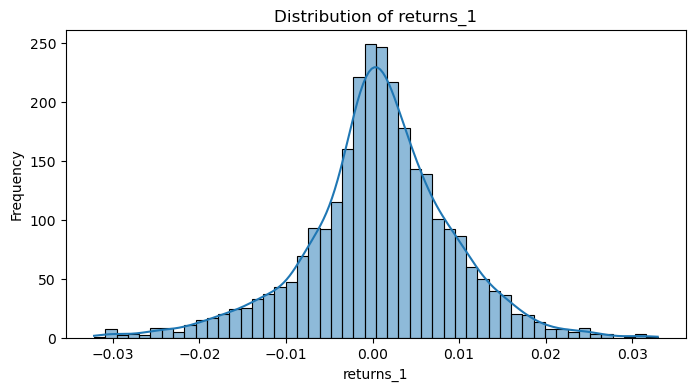

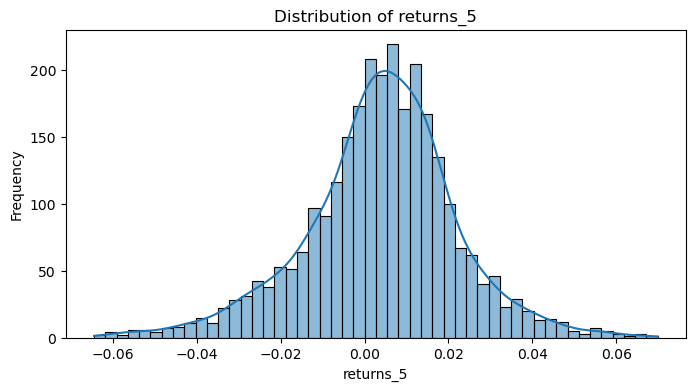

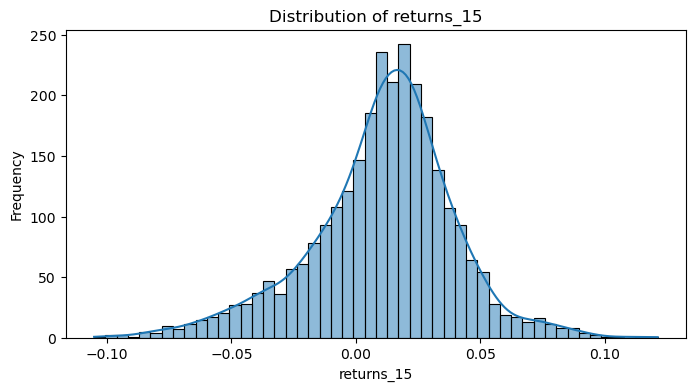

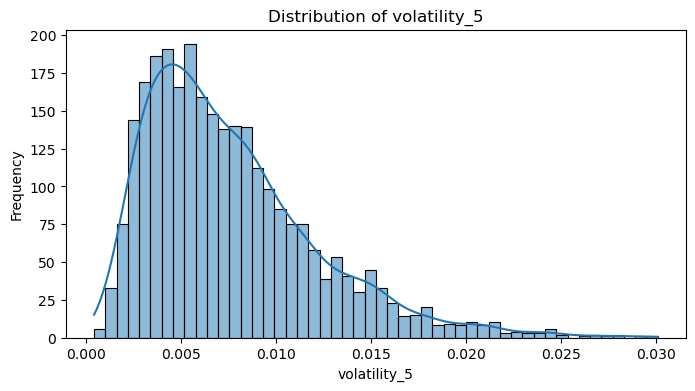

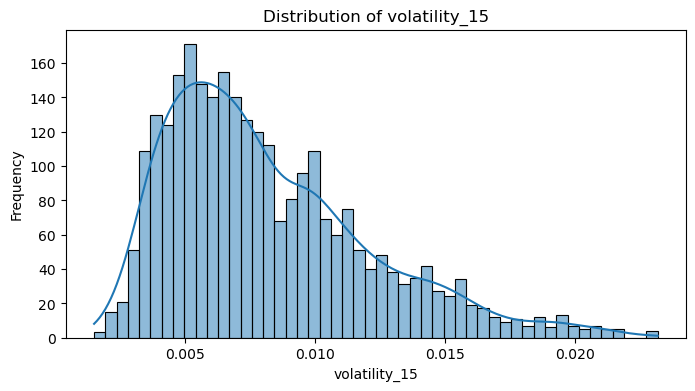

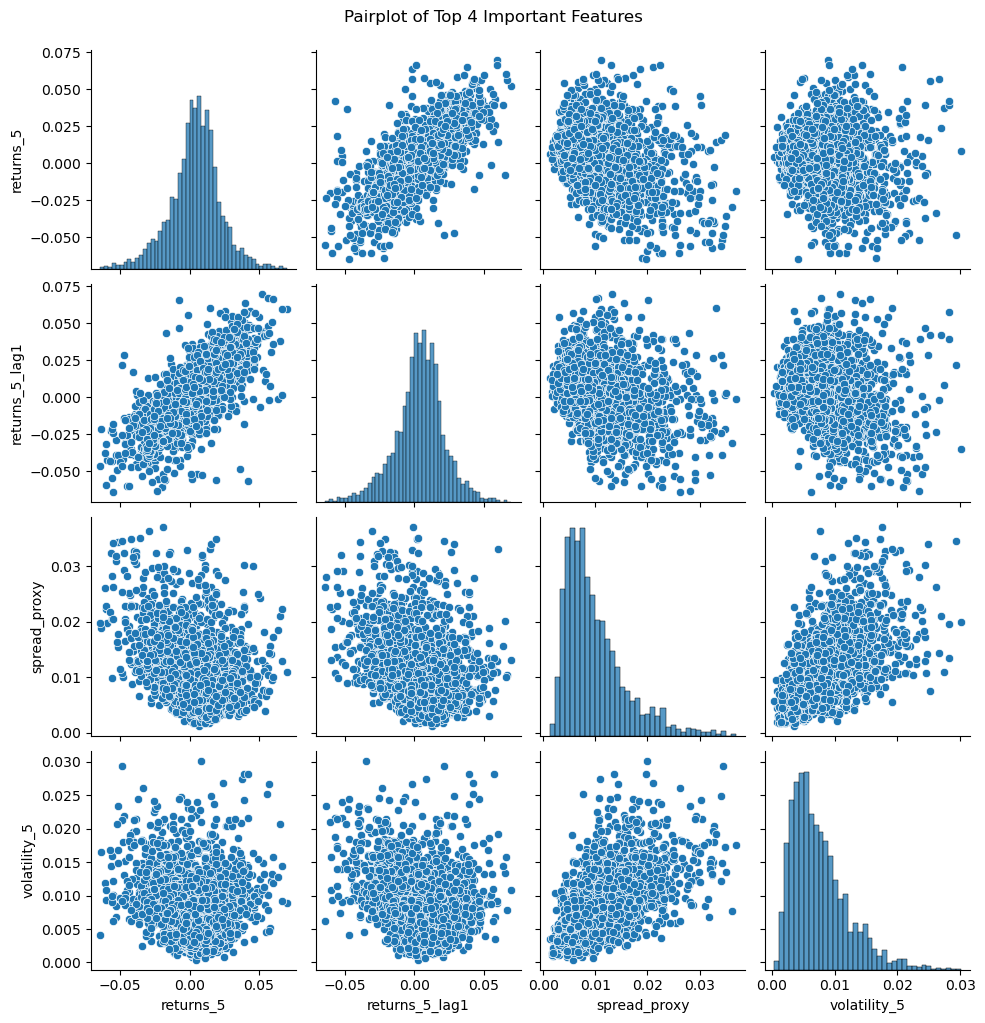

In [12]:
# Additional visualizations for tick-level features
import matplotlib.dates as mdates

# Plot rolling volatility and moving averages
if any('volatility' in col for col in clean_features_df.columns):
    plt.figure(figsize=(14, 5))
    for col in [c for c in clean_features_df.columns if 'volatility' in c]:
        plt.plot(clean_features_df.index, clean_features_df[col], label=col)
    plt.title('Rolling Volatility')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()

if any('ma_' in col for col in clean_features_df.columns):
    plt.figure(figsize=(14, 5))
    for col in [c for c in clean_features_df.columns if c.startswith('ma_')]:
        plt.plot(clean_features_df.index, clean_features_df[col], label=col)
    plt.title('Moving Averages')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

# Distribution plots for key features
import seaborn as sns
for col in feature_cols[:5]:  # Plot first 5 features for brevity
    plt.figure(figsize=(8, 4))
    sns.histplot(clean_features_df[col].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Pairplot for top 4 important features (if available)
if 'importance_df' in locals() and not importance_df.empty:
    top_features = importance_df['feature'].head(4).tolist()
    sns.pairplot(clean_features_df[top_features].dropna())
    plt.suptitle('Pairplot of Top 4 Important Features', y=1.02)
    plt.show()

In [13]:
# Save engineered tick-level data to a new ArcticDB database
from src.data.arcticdb_store import ArcticDBStore

# Use the main financial_data directory at the project root
project_db_path = os.path.abspath(os.path.join(os.getcwd(), "..", "financial_data"))
new_db_store = ArcticDBStore(db_url=f"lmdb://{project_db_path}", library_name="tick_data")

# Save the cleaned and engineered tick data (using the same ticker name for demo)
ticker_name = ticker  # Use the symbol actually loaded
new_db_store.write(ticker_name, clean_features_df)
print(f"Tick-level engineered data for {ticker_name} saved to ArcticDB library 'tick_data'.")

Tick-level engineered data for ENGINEERED/SAMPLE saved to ArcticDB library 'tick_data'.
